# Import Libraries

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 9)

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Functions

## Camera Calibration

In [2]:
def camera_calibration(nx, ny, images, show_steps = 0, show_images = 0):
    """
    Compute the camera calibration matrix and distortion coefficients.
    They are computed once and we will apply them to undistort each new frame.
    """
    print("We have {} images for calibration.".format(len(images)))
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    
    for fname in images:
        img  = mpimg.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        img_corners = img.copy()
        
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)
        
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img_corners, (nx,ny), corners, ret)   
        
        if show_steps == 1:
            if ret == True:
                print("Current image is '{}' and is successfully calibrated".format(fname.split("/")[-1]))
            else:
                print("Current image is '{}' and is failed to calibrate".format(fname.split("/")[-1]))
                
        if show_images == 1:
            image_name = "camera_calibration: "+ fname.split("/")[-1]
            plt.figure(figsize=(15,3))
            plt.suptitle(image_name)
            plt.subplot(1,3,1)
            plt.imshow(img)
            plt.title("Original Image")
            plt.subplot(1,3,2)
            plt.imshow(gray,cmap='gray')
            plt.title("Gray Image")
            if ret == True:
                plt.subplot(1,3,3)
                plt.imshow(img_corners)
                plt.title("Image with Corners")     
            plt.savefig("output_images/"+image_name)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    print("Calibration is finished")
    return ret, mtx, dist, rvecs, tvecs

images = glob.glob('camera_cal/calibration*.jpg')
nx = 9 #the number of inside corners in x
ny = 6 #the number of inside corners in y    
ret, mtx, dist, rvecs, tvecs = camera_calibration(nx, ny, images, show_steps = 0,  show_images = 0)

We have 20 images for calibration.
Calibration is finished


## Distortion Correction

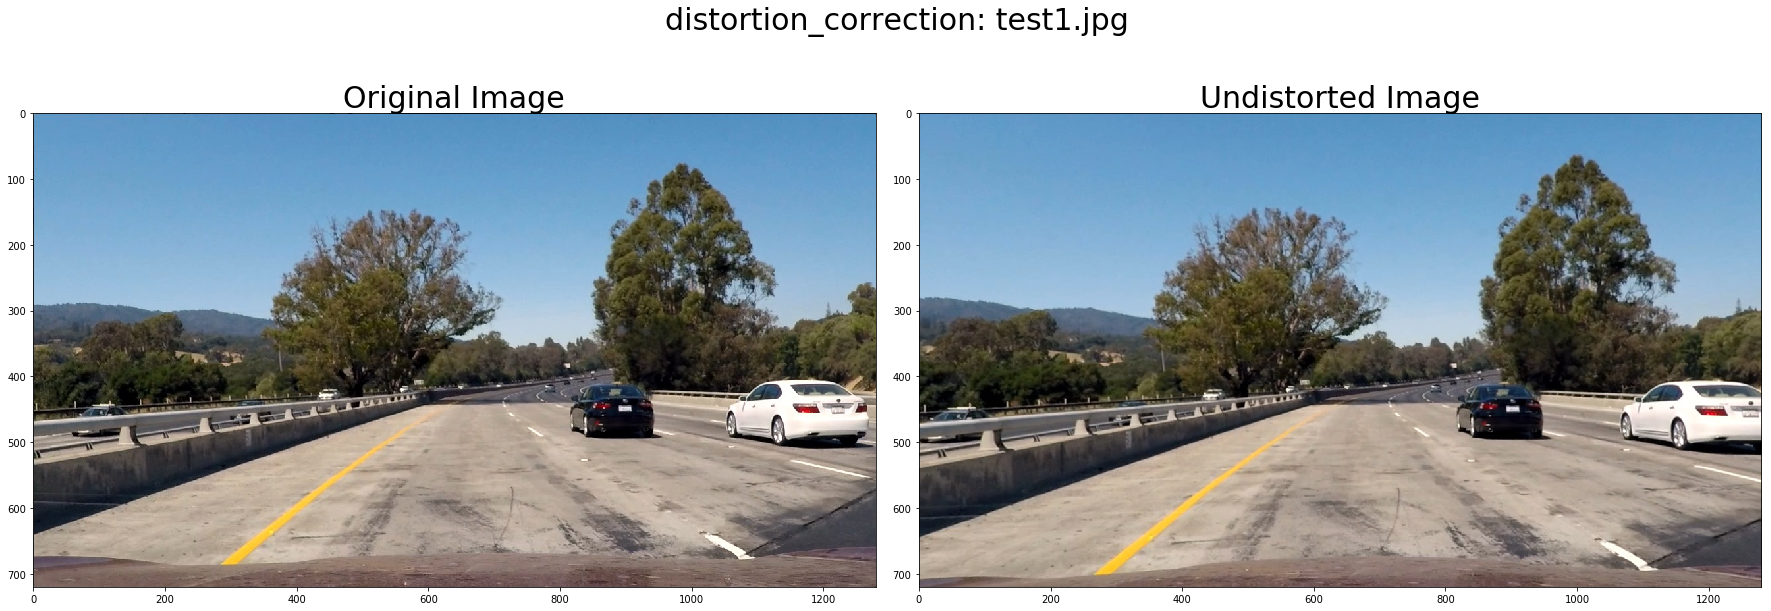

In [3]:
def distortion_correction(img, mtx, dist, debug=0):
    """
    The function transforms an image to compensate radial and tangential lens distortion.
    undistort(src, cameraMatrix, distCoeffs[, dst[, newCameraMatrix]]) -> dst
    """
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    if debug == 1:
        # Plot the result
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=30)
        ax2.imshow(undistorted)
        ax2.set_title('Undistorted Image', fontsize=30)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return undistorted

if 1:
    images = glob.glob('test_images/test1*.jpg')
    for fname in images:
        img  = mpimg.imread(fname)  
        undistorted = distortion_correction(img, mtx, dist, debug = 1)
        
        image_name = "distortion_correction: "+ fname.split("/")[-1]
        plt.suptitle(image_name, fontsize=30)
        plt.savefig("output_images/"+image_name)

## Color Threshold

In [4]:
def color_threshold(img, thresh=(0, 255), debug = 0):
    """
    function that thresholds the S-channel of HLS
    """
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    
    if debug == 1:
        # Plot the result
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        #plt.suptitle("Change", fontsize=30)
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=30)
        ax2.imshow(binary_output, cmap='gray')
        ax2.set_title('Thresholded S', fontsize=30)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
    return binary_output

if 0:
    images = glob.glob('test_images/*.jpg')
    for fname in images:
        img  = mpimg.imread(fname)    
        undistorted = distortion_correction(img, mtx, dist, debug = 0)
        binary_output = color_threshold(undistorted, thresh=(170, 255), debug = 1)
        image_name = "color_threshold: "+ fname.split("/")[-1]
        plt.suptitle(image_name, fontsize=30)
        plt.savefig("output_images/"+image_name)

## Gradient Thresholds 

In [5]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, mag_thresh=(0, 255)):
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel>mag_thresh[0]) & (scaled_sobel<=mag_thresh[1])] = 1
    
    return binary_output
 
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.sqrt(np.power(sobel_x,2) + np.power(sobel_y,2))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel>mag_thresh[0]) & (scaled_sobel<=mag_thresh[1])] = 1
    return binary_output


def dir_threshold(img, sobel_kernel=3, rad_thresh=(0, np.pi/2)):
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)

    gradient_sobel = np.arctan2(abs_sobel_y, abs_sobel_x)

    binary_output = np.zeros_like(gradient_sobel)

    binary_output[(gradient_sobel>=rad_thresh[0]) & (gradient_sobel<=rad_thresh[1])] = 1

    return binary_output

## Color and gradient 

In [6]:
def color_gradient_threshold(img, s_thresh=(150, 255), sx_thresh=(100, 255), debug = 0):
    """
    Steps:
        - Convert to HLS color space and separate the V channel
    """
    s_binary = color_threshold(img, thresh=s_thresh)
    
    s_channel = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    sxbinary = abs_sobel_thresh(s_channel, orient='x', sobel_kernel=3, mag_thresh=sx_thresh)
    
    binary_output = np.zeros_like(s_binary)
    binary_output[(s_binary == 1) | (sxbinary == 1)] = 1
    
    if debug == 1:
        s_binary_color = np.dstack((np.zeros_like(sxbinary), np.zeros_like(sxbinary), s_binary)) * 255
        sxbinary_color = np.dstack((np.zeros_like(sxbinary), sxbinary, np.zeros_like(sxbinary))) * 255
        color_binary   = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255      

        plt.figure(figsize=(24, 14))
        fontsize = 20
        plt.subplot(2,2,1)
        plt.imshow(img)
        plt.title("Original Image", fontsize=fontsize)
        plt.subplot(2,2,2)
        plt.imshow(s_binary_color)
        plt.title("S theshold", fontsize=fontsize)
        plt.subplot(2,2,3)
        plt.imshow(sxbinary_color)
        plt.title("Sobel x, gradient threshold", fontsize=fontsize)
        plt.subplot(2,2,4)
        plt.imshow(color_binary)
        plt.title("Combined S channel and gradient thresholds", fontsize=fontsize)
       
    return binary_output

if 0:   
    images = glob.glob('test_images/*.jpg')
    for fname in images:
        img  = mpimg.imread(fname)
        undistorted = distortion_correction(img, mtx, dist)
        binary_output = color_gradient_threshold(undistorted, debug = 0)
        binary_warped, M, Minv = perspective_transform(binary_output, plot = 0)
        plt.figure()
        plt.subplot(1,3,1)
        plt.imshow(undistorted);
        plt.subplot(1,3,2)
        plt.imshow(binary_output,cmap="gray");
        plt.subplot(1,3,3)
        plt.imshow(binary_warped, cmap="gray");
        


if 0:   
    images = glob.glob('test_images/*.jpg')
    for fname in images:
        img  = mpimg.imread(fname)
        undistorted = distortion_correction(img, mtx, dist)
        binary_warped, M, Minv = perspective_transform(undistorted, plot = 1)
        binary_output = color_gradient_threshold(binary_warped, debug = 1)
        image_name = "color_gradient_threshold: "+ fname.split("/")[-1]
        plt.suptitle(image_name, fontsize=30)
        plt.savefig("output_images/"+image_name)
        plt.figure()
        plt.imshow(binary_output,cmap="gray");

## Perspective Transform

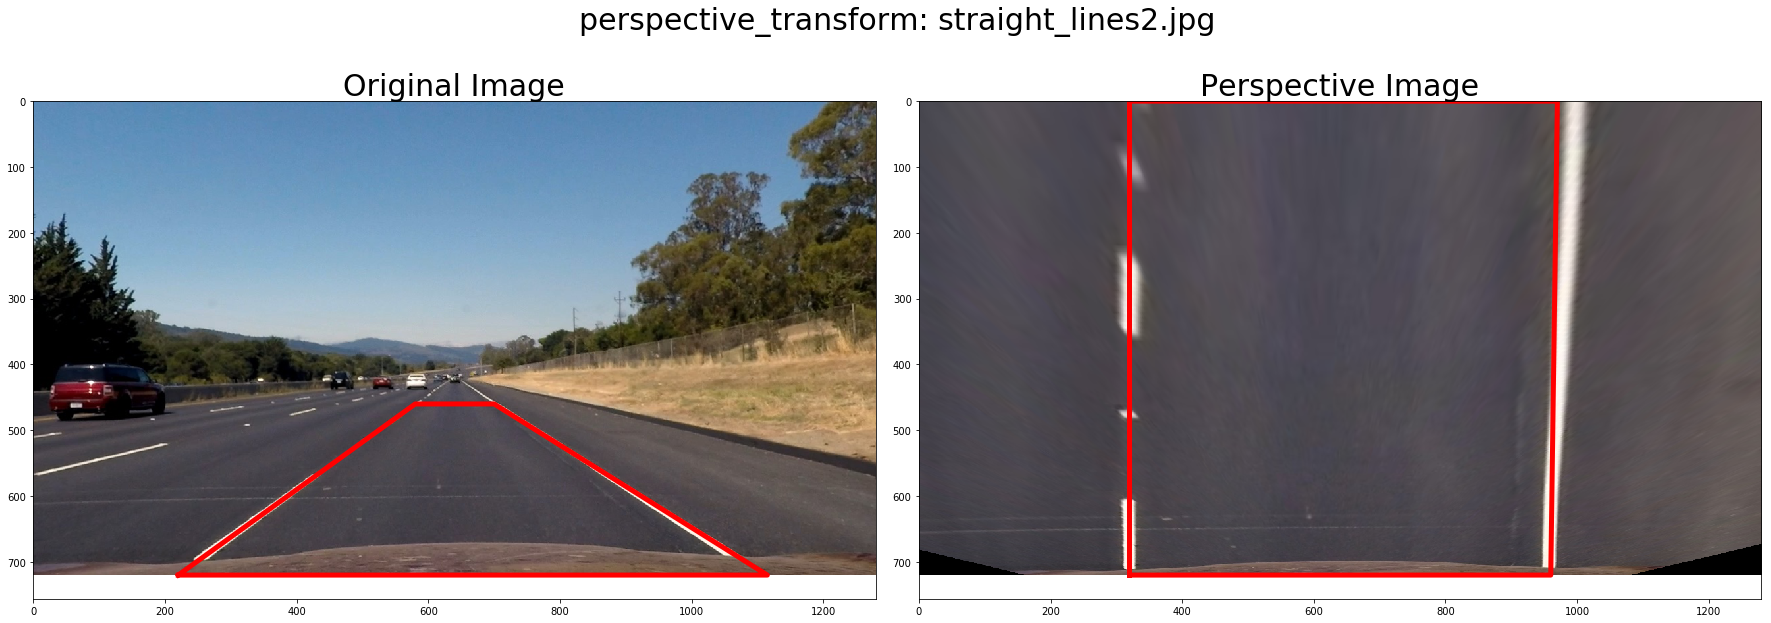

In [7]:
def perspective_transform(img, offset = 0, plot = 0):
    """
    src = np.float32([[210, imshape[0]],
                      [520, 500], 
                      [765, 500], 
                      [1100, imshape[0]]])
                      
    src = np.float32([[210,  img_size[1]],
                      [595,  450], 
                      [688,  450], 
                      [1100, img_size[1]]])
    """
    img_size = (img.shape[1],img.shape[0])
    """
    src_bottom_left  = (210,  img_size[1])
    src_upper_left   = (595,  450)
    src_upper_right  = (688,  450)
    src_bottom_right = (1100, img_size[1])

    src_bottom_left  = (0,    620)
    src_upper_left   = (540,  450)
    src_upper_right  = (740,  450)
    src_bottom_right = (1280, 620)

    src_bottom_left  = (255,  650)
    src_upper_left   = (505,  500)
    src_upper_right  = (800,  500)
    src_bottom_right = (1100, 650)

    src_bottom_left  = (0,    720)
    src_upper_left   = (570,  450)
    src_upper_right  = (710,  450)
    src_bottom_right = (1280, 720)
    
    src_bottom_left  = (0,    700)
    src_upper_left   = (565,  450)
    src_upper_right  = (710,  450)
    src_bottom_right = (1280, 700)
    
    """
    
    src_bottom_left  = (220, 720)
    src_upper_left   = (580, 460)
    src_upper_right  = (700, 460)
    src_bottom_right = (1115, 720)
                        
    dst_bottom_left  = (320, 720)
    dst_upper_left   = (320, 0)
    dst_upper_right  = (970, 0)
    dst_bottom_right = (960, 720) 
    
    """
    dst_bottom_left  = (offset,              img_size[1]-offset)
    dst_upper_left   = (offset,              offset)
    dst_upper_right  = (img_size[0]-offset,  offset)
    dst_bottom_right = (img_size[0]-offset,  img_size[1]-offset) 
    """
    src = np.float32([src_bottom_left, src_upper_left, src_upper_right, src_bottom_right])
    dst = np.float32([dst_bottom_left, dst_upper_left, dst_upper_right, dst_bottom_right])
    """
    img_size = img.shape
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    """
    
    M    = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    binary_warped = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)
    
    
    if plot == 1:
        src_x = [src[0][0], src[1][0], src[2][0], src[3][0], src[0][0]]
        src_y = [src[0][1], src[1][1], src[2][1], src[3][1], src[0][1]]
        
        dst_x = [dst[0][0], dst[1][0], dst[2][0], dst[3][0], dst[0][0]]
        dst_y = [dst[0][1], dst[1][1], dst[2][1], dst[3][1], dst[0][1]]
                
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img);
        ax1.plot(src_x, src_y, 'r', lw=5);
        ax1.set_title('Original Image', fontsize=30)
        
        ax2.imshow(binary_warped, cmap="gray");
        ax2.plot(dst_x, dst_y, 'r', lw=5);
        ax2.set_title('Perspective Image', fontsize=30)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    return binary_warped, M, Minv

if 1:
    images = glob.glob('test_images/straight_lines2*.jpg')
    for fname in images:
        img  = mpimg.imread(fname)
        undistorted = distortion_correction(img, mtx, dist)
        #binary_output = color_gradient_threshold(undistorted, debug = 0)
        binary_warped, M, Minv = perspective_transform(undistorted, plot = 1)
        image_name = "perspective_transform: "+ fname.split("/")[-1]
        plt.suptitle(image_name, fontsize=30)
        plt.savefig("output_images/"+image_name)

# =============================================================

In [8]:
def add_lane_line_to_graph(left_fitx, right_fitx, ploty):
    """
    Plot the polynomial lines onto the image
    
    Input: 
        left_fitx, right_fitx, ploty:x and y values for lane's plotting
    """
    plt.plot(left_fitx,  ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

In [9]:
def find_lane_pixels(binary_warped, nwindows = 20, margin = 100, minpix = 10):
    """
    HYPERPARAMETERS:
        - nwindows  # Choose the number of sliding windows
        - margin    # Set the width of the windows +/- margin
        - minpix    # Set minimum number of pixels found to recenter window
    
    steps:
    - histogram:               Take a histogram of the bottom half of the image
    - out_img:                 Create an output image to draw on and visualize the result 
    - leftx_base:              Find the peak of the left half of the histogram as starting point for lane
    - rightx_base:             Find the peak of the right half of the histogram as starting point for lane
    - window_height:           Set height of windows - based on nwindows above and image shape
    - nonzero:                 Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    - leftx_current:           Current positions to be updated later for each window in nwindows
    - rightx_current:          Current positions to be updated later for each window in nwindows
    - left_lane_inds:          Create empty lists to receive left and right lane pixel indices
    - right_lane_inds:         Create empty lists to receive left and right lane pixel indices
    - Iterate through nwindows to track curvature
        - Identify window boundaries in x and y (and right and left)
        - Draw the windows on the visualization image
        - Identify the nonzero pixels in x and y within the window
        - Append these indices to the lists
        - If you found > minpix pixels, recenter next window on their mean position
    - Concatenate the arrays of indices (previously was a list of lists of pixels)
    - Extract left and right line pixel positions
    
    Important funtions
    - cv2.rectangle(image, start_point, end_point, color, thickness)
        - method is used to draw a rectangle on any image.
    - numpy.polyfit(x, y, deg, rcond=None, full=False, w=None, cov=False)
        - Least squares polynomial fit

    Return:
    - leftx, lefty, rightx, righty: left and right line pixel positions
    - out_img                     : visulaization of the windows
    """
    out_img   = np.dstack((binary_warped, binary_warped, binary_warped)) # the output image with windows and lanes
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    midpoint  = np.int(histogram.shape[0]//2)
    
    leftx_base  = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    nonzero  = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current  = leftx_base
    rightx_current = rightx_base
    
    left_lane_inds  = []
    right_lane_inds = []
    
    for window in range(nwindows):
        win_y_low       = binary_warped.shape[0] - (window+1)*window_height
        win_y_high      = binary_warped.shape[0] -  window   *window_height
        win_xleft_low   = leftx_current  - margin
        win_xleft_high  = leftx_current  + margin
        win_xright_low  = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),  (win_xleft_high,win_y_high), (0,255,0), 4) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low), (win_xright_high,win_y_high),(0,255,0), 4) 
        
        good_left_inds  = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    left_lane_inds  = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx  = nonzerox[left_lane_inds]
    lefty  = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img

In [10]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    """
    Fit a second order polynomial to each with np.polyfit()
    
    Function used:
        # numpy.polyfit(x, y, deg, rcond=None, full=False, w=None, cov=False)
        # numpy.linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None, axis=0)
    
    """
    global left_fit
    global right_fit 
    
    ploty     = np.linspace(0, img_shape[0]-1, img_shape[0])
    if len(leftx) != 0:
        left_fit  = np.polyfit(lefty, leftx, 2)
    else:
        #print("len(leftx) == 0")
        pass
        
    if len(rightx) != 0:    
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        #print("len(rightx) == 0")
        pass

    # Generate x and y values for plotting
    ploty      = np.linspace(0, img_shape[0]-1, img_shape[0] )
    left_fitx  = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]        
        
    return left_fit, right_fit, left_fitx, right_fitx, ploty

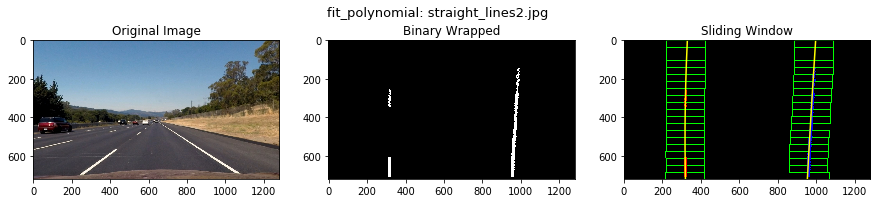

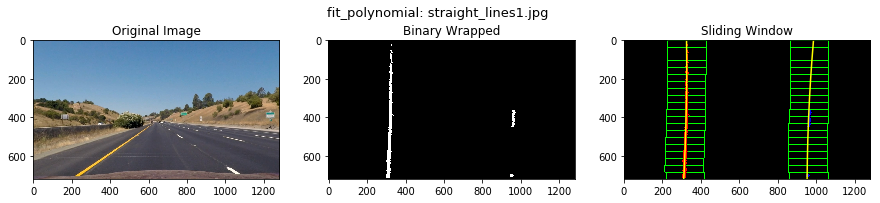

In [11]:
def fit_polynomial(binary_warped):
    """
    Steps:
        - Find our lane pixels first
        - Fit a second order polynomial to each using `np.polyfit`
        - Generate x and y values for plotting
        - Color the left pixels with Red
        - Color the right pixels withe Blue
    """    
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
            
    out_img[lefty, leftx]   = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]    
    
    return leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx, ploty, out_img

if 1:
    images = glob.glob('test_images/stra*.jpg')
    for fname in images:
        img  = mpimg.imread(fname)
        undistorted = distortion_correction(img, mtx, dist)
        binary_output = color_gradient_threshold(undistorted, debug = 0)
        binary_warped, M, Minv = perspective_transform(binary_output, plot = 0) 
        leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx, ploty, out_img = fit_polynomial(binary_warped)
        
        plt.figure(figsize=(15,3))
        plt.subplot(1,3,1)
        plt.imshow(undistorted)
        plt.title("Original Image")
        plt.subplot(1,3,2)
        plt.imshow(binary_warped, cmap='gray')
        plt.title("Binary Wrapped")
        plt.subplot(1,3,3)
        plt.imshow(out_img)
        plt.title("Sliding Window")
        add_lane_line_to_graph(left_fitx, right_fitx, ploty)
        
        image_name = "fit_polynomial: "+ fname.split("/")[-1]
        plt.suptitle(image_name, fontsize=13)
        plt.savefig("output_images/"+image_name)

In [12]:
#left_fit  = [0, 0, 0]
#right_fit = [0, 0, 0]
def search_around_poly(binary_warped, margin = 100, minpix = 50):
    """
    HYPERPARAMETERS:
        - margin    # Set the width of the windows +/- margin
    
    Steps:
        - Grab activated pixels
        - Set the area of search based on activated x-values within the +/- margin of our polynomial function
        - Extract left and right line pixel positions
        - Fit new polynomials
    """
    global left_fit
    global right_fit
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
        
    left_lane_inds  = ((nonzerox > (left_fit [0]*(nonzeroy**2) + left_fit[1] *nonzeroy + left_fit[2]  - margin)) & 
                       (nonzerox < (left_fit [0]*(nonzeroy**2) + left_fit[1] *nonzeroy + left_fit[2]  + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & 
                       (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    leftx  = nonzerox[left_lane_inds]
    lefty  = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    img_shape = binary_warped.shape
    
    if (len(leftx) < minpix) or (len(rightx) < minpix):
        #print("Sliding Window Approach")
        leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx, ploty, out_img = fit_polynomial(binary_warped)
        return leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx, ploty, out_img
    else:
        left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(img_shape, leftx, lefty, rightx, righty)
        if left_fit.sum() == right_fit.sum():
            leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx, ploty, out_img = fit_polynomial(binary_warped)
            return leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx, ploty, out_img
            
    
    ## Start visualization steps ##
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    out_img[lefty,  leftx]  = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    cv2.fillPoly(window_img, np.int_([left_line_pts]),  (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    
    out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    ## End visualization steps ##
    return leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx, ploty, out_img

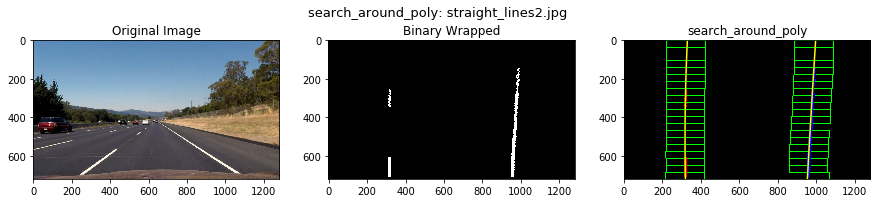

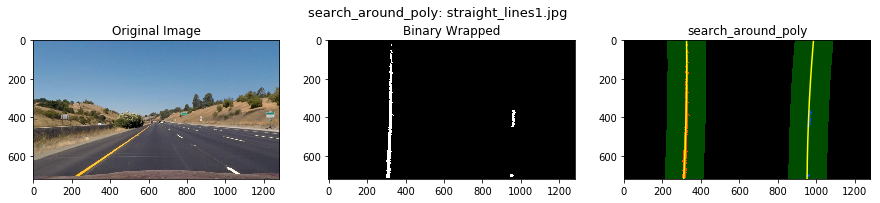

In [13]:
left_fit  = [0, 0, 0]
right_fit = [0, 0, 0]
if 1:
    images = glob.glob('test_images/stra*.jpg')
    for fname in images:
        img  = mpimg.imread(fname)
        undistorted = distortion_correction(img, mtx, dist)
        binary_output = color_gradient_threshold(undistorted, debug = 0)
        binary_warped, M, Minv = perspective_transform(binary_output, plot = 0) 
        leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx, ploty, out_img = search_around_poly(binary_warped)
        #newwarp = cv2.warpPerspective(out_img, Minv, (binary_warped.shape[1], binary_warped.shape[0])) 
        #out_img = cv2.addWeighted(undistorted, 1, newwarp, 1, 0) 
        
        
        #print(left_fit,right_fit)
        plt.figure(figsize=(15,3))
        plt.subplot(1,3,1)
        plt.imshow(undistorted)
        plt.title("Original Image")
        plt.subplot(1,3,2)
        plt.imshow(binary_warped, cmap='gray')
        plt.title("Binary Wrapped")
        plt.subplot(1,3,3)
        plt.imshow(out_img)
        plt.title("search_around_poly")
        add_lane_line_to_graph(left_fitx, right_fitx, ploty)
        
        image_name = "search_around_poly: "+ fname.split("/")[-1]
        plt.suptitle(image_name, fontsize=13)
        plt.savefig("output_images/"+image_name)

In [14]:
def measure_curvature_real(leftx, lefty, rightx, righty):
    '''
    Calculate the radius of curvature in meters for both lane lines
    Input:
        - leftx, lefty, rightx, righty: left and right line pixel positions
    Output:
        - left_curverad, right_curverad: curvature in meters
    steps:
        - Define conversions in x and y from pixels space to meters
        - Fit a second order polynomial
        - We'll choose the maximum y-value, corresponding to the bottom of the image
        - Calculation of R_curve (radius of curvature)
    '''
    global left_fit_cr
    global right_fit_cr
    
    ym_per_pix = 30 /720 
    xm_per_pix = 3.7/700
    
    if (len(leftx)) != 0:
        left_fit_cr  = np.polyfit(lefty *ym_per_pix, leftx *xm_per_pix, 2)
    else:
        #print("len(leftx) == 0")
        pass
        
    if (len(rightx)) != 0:
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    else:
        #print("len(leftx) == 0")
        pass
        
    y_eval = np.max(ploty)
    
    left_curverad  = ((1 + (2*left_fit_cr [0]*y_eval*ym_per_pix + left_fit_cr [1])**2)**1.5) / np.absolute(2*left_fit_cr [0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])    
    
    return left_curverad, right_curverad

left_curverad, right_curverad = measure_curvature_real(leftx, lefty, rightx, righty)
print(left_curverad, right_curverad)

3720.61274172 3042.48256155


In [15]:
def measure_car_offset(left_fitx, right_fitx, image_center):
    xm_per_pix = 3.7/700
    car_offset_pixel = image_center - (left_fitx[-1] + right_fitx[-1])/2
    car_offset_meter = car_offset_pixel * xm_per_pix
    return car_offset_meter

In [16]:
def add_curvature_image(image, left_curverad, right_curverad, car_offset_meter):
    """
    Syntax: cv2.putText(image, text, org, font, fontScale, color[, thickness[, lineType[, bottomLeftOrigin]]])

    Parameters:
        - image:            It is the image on which text is to be drawn.
        - text:             Text string to be drawn.
        - org:              It is the coordinates of the bottom-left corner of the text string in the image. The coordinates are represented as tuples of two values i.e. (X coordinate value, Y coordinate value).
        - font:             It denotes the font type. Some of font types are FONT_HERSHEY_SIMPLEX, FONT_HERSHEY_PLAIN, , etc.
        - fontScale:        Font scale factor that is multiplied by the font-specific base size.
        - color:            It is the color of text string to be drawn. For BGR, we pass a tuple. eg: (255, 0, 0) for blue color.
        - thickness:        It is the thickness of the line in px.
        - lineType:         This is an optional parameter.It gives the type of the line to be used.
        - bottomLeftOrigin: This is an optional parameter. When it is true, the image data origin is at the bottom-left corner. Otherwise, it is at the top-left corner.

    Return Value: 
      - It returns an image.
    """
    font      = cv2.FONT_HERSHEY_SIMPLEX 
    fontScale = 2                        
    color     = (255, 255, 255)
    thickness =  2    
    
    c_text = "Radius of Curvature {:.0f}m".format((left_curverad + right_curverad)/2) 
    if car_offset_meter>0:
        o_text = "Vehicle is {:.2f}m right of center".format(car_offset_meter)
    else:
        o_text = "Vehicle is {:.2f}m left of center".format(-car_offset_meter)
        
    
    c_org  = (120,60) 
    o_org  = (120,120) 
    
    out_img = image.copy()
    cv2.putText(out_img, c_text, c_org, font, fontScale, color, thickness, cv2.LINE_AA)
    cv2.putText(out_img, o_text, o_org, font, fontScale, color, thickness, cv2.LINE_AA)
    return out_img

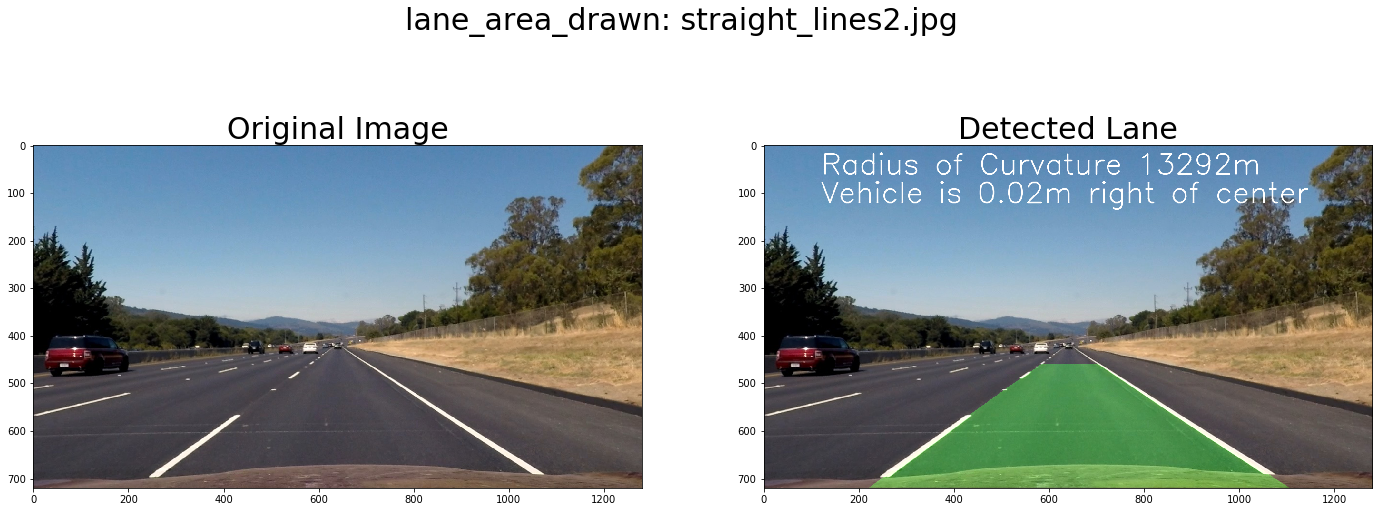

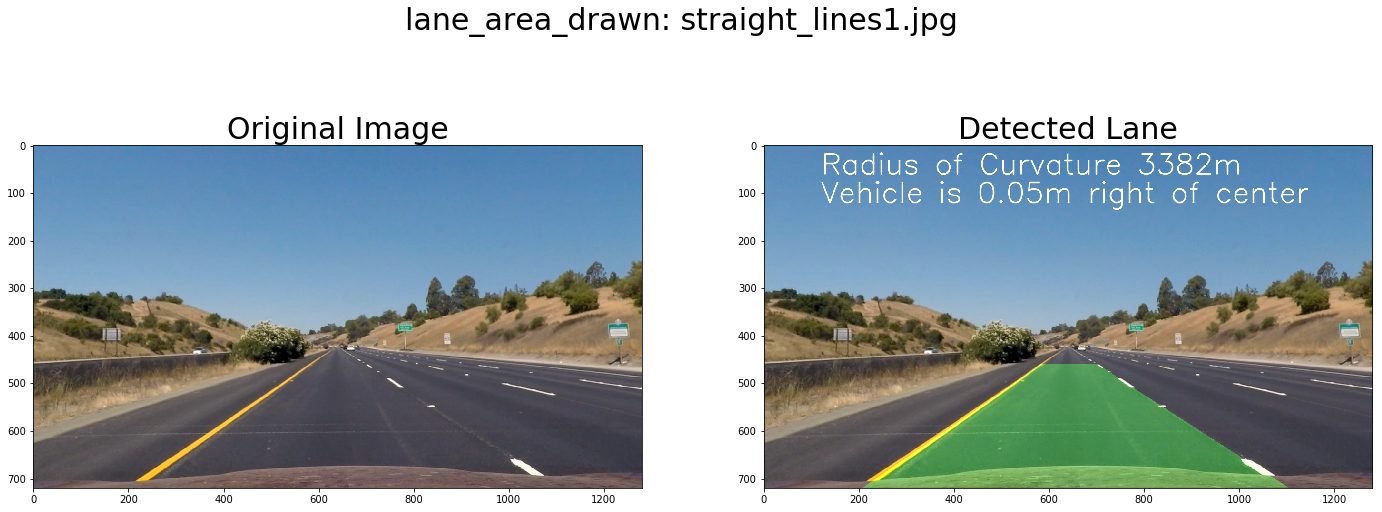

In [17]:
def lane_area_drawn(binary_warped, undistorted , ploty, left_fitx, right_fitx, Minv, left_curverad, right_curverad, car_offset_meter):
    """
    Steps:
        - color_warp: Create an image to draw the lines on
        - pts:        Recast the x and y points into usable format for cv2.fillPoly()
        - Draw the lane onto the warped blank image
        - Warp the blank back to original image space using inverse perspective matrix (Minv)
        - Combine the result with the original image
        - Add Curvature information
    
    """
    warp_zero  = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    pts_left  = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts       = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1], binary_warped.shape[0])) 
    out_img = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    out_img = add_curvature_image(out_img, left_curverad, right_curverad, car_offset_meter)
    return out_img

if 1:
    images = glob.glob('test_images/str*.jpg')
    for fname in images:
        img  = mpimg.imread(fname)
        undistorted = distortion_correction(img, mtx, dist)
        binary_output = color_gradient_threshold(undistorted, debug = 0)
        binary_warped, M, Minv = perspective_transform(binary_output, plot = 0) 
        leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx, ploty, out_img = search_around_poly(binary_warped)
        left_curverad, right_curverad = measure_curvature_real(leftx, lefty, rightx, righty)
        car_offset_meter = measure_car_offset(left_fitx, right_fitx, img.shape[1]//2)
        Ouput = lane_area_drawn(binary_warped, undistorted, ploty, left_fitx, right_fitx, Minv, left_curverad, right_curverad, car_offset_meter)        
        
        plt.figure(figsize=(24, 9))
        plt.subplot(1,2,1)
        plt.imshow(undistorted)
        plt.title("Original Image",fontsize=30)
        plt.subplot(1,2,2)
        plt.imshow(Ouput)
        plt.title("Detected Lane",fontsize=30)
        
        image_name = "lane_area_drawn: "+ fname.split("/")[-1]
        plt.suptitle(image_name, fontsize=30)
        plt.savefig("output_images/"+image_name)

## Pipeline

In [18]:
# Compute the camera calibration matrix and distortion coefficients. 
nx = 9 #the number of inside corners in x
ny = 6 #the number of inside corners in y  
images = glob.glob('camera_cal/calibration*.jpg')
ret, mtx, dist, rvecs, tvecs = camera_calibration(nx, ny, images, show_steps = 0,  show_images = 0) 

We have 20 images for calibration.
Calibration is finished


In [19]:
def lane_line_pipeline(img):
    global left_fit
    global right_fit
    
    undistorted = distortion_correction(img, mtx, dist)
    binary_output = color_gradient_threshold(undistorted, debug = 0)
    binary_warped, M, Minv = perspective_transform(binary_output, plot = 0) 
    leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx, ploty, out_img = search_around_poly(binary_warped)
    left_curverad, right_curverad = measure_curvature_real(leftx, lefty, rightx, righty)
    car_offset_meter = measure_car_offset(left_fitx, right_fitx, img.shape[1]//2)
    Ouput = lane_area_drawn(binary_warped, undistorted, ploty, left_fitx, right_fitx, Minv, left_curverad, right_curverad, car_offset_meter)        
    #newwarp = cv2.warpPerspective(out_img, Minv, (binary_warped.shape[1], binary_warped.shape[0])) 
    #out_img = cv2.addWeighted(undistorted, 1, newwarp, 0.5, 0)
    #Ouput = cv2.hconcat([Ouput, out_img])
    return Ouput

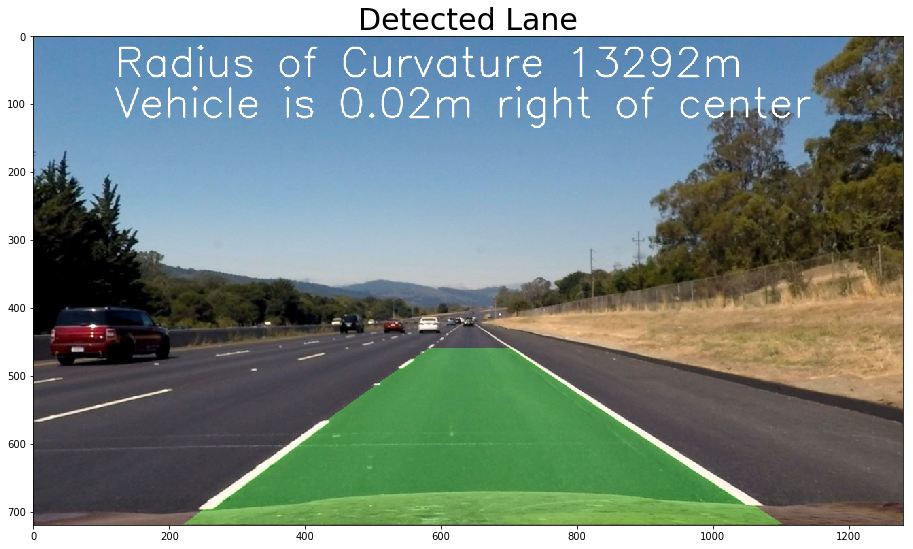

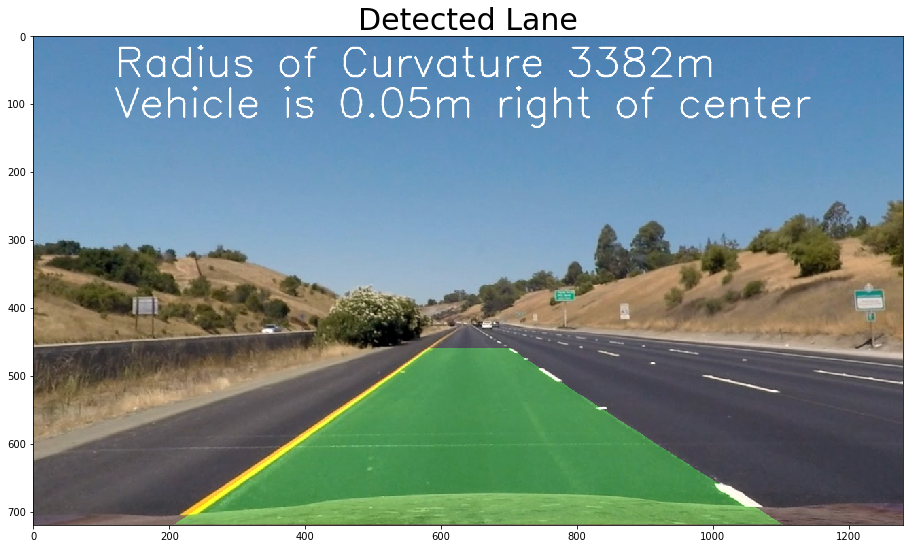

In [20]:
images = glob.glob('test_images/straight_lines*.jpg')
for fname in images:
    img  = mpimg.imread(fname)
    Ouput = lane_line_pipeline(img)
    plt.figure(figsize=(24, 9))
    plt.imshow(Ouput)
    plt.title("Detected Lane",fontsize=30) 
    image_name = "lane_line_pipeline: "+ fname.split("/")[-1]
    plt.savefig("output_images/"+image_name)

In [21]:
if 0:
    images = glob.glob('test_images/straight_lines1.jpg')
    for fname in images:
        img  = mpimg.imread(fname)
        undistorted = distortion_correction(img, mtx, dist)
        binary_output = color_gradient_threshold(undistorted, debug = 0)
        binary_warped, M, Minv = perspective_transform(binary_output, plot = 0) 
        leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx, ploty, out_img = search_around_poly(binary_warped)
        left_curverad, right_curverad = measure_curvature_real(leftx, lefty, rightx, righty)
        car_offset_meter = measure_car_offset(left_fitx, right_fitx, img.shape[1]//2)
        Ouput = lane_area_drawn(binary_warped, undistorted, ploty, left_fitx, right_fitx, Minv, left_curverad, right_curverad, car_offset_meter)      
        
        
        newwarp = cv2.warpPerspective(out_img, Minv, (binary_warped.shape[1], binary_warped.shape[0])) 
        out_img = cv2.addWeighted(undistorted, 1, newwarp, 0.5, 0)
        
        Ouput = cv2.hconcat([Ouput, out_img])
        
        plt.figure(figsize=(24,12))
        plt.imshow(Ouput)

# Video

In [22]:
def process_image(image):
    result = lane_line_pipeline(image)
    return result

In [ ]:
left_fit  = [0, 0, 0]
right_fit = [0, 0, 0]
input_video = 'project_video.mp4'
output_video = "Output_"+input_video.split("/")[-1]
clip = VideoFileClip(input_video)#.subclip(23,27)
out_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video Output_project_video.mp4
[MoviePy] Writing video Output_project_video.mp4


 45%|████▌     | 570/1261 [01:43<02:19,  4.95it/s]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))